In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv('glass.csv', engine='pyarrow')
data['type'] = data['type'].astype('category')

X = data['RI'].to_numpy()

In [2]:
from scipy import stats as st


def rescale(x: np.ndarray):
    return (x - x.min())/(x.max() - x.min())

def j_hat_hist(x: np.ndarray, m: int):
    n = len(x)
    X_min = x.min()
    X_max = x.max()

    p_hat = np.array([
        np.sum((x >= j/m) & (x < (j+1)/m)) if j < m-1 else np.sum((x >= j/m) & (x <= (j+1)/m)) for j in range(m) 
    ])/n

    def get_bin(t):
        return np.maximum(np.minimum(np.floor(m * (t - X_min) / (X_max - X_min)).astype(int), m - 1), 0)

    return m*(2/(n-1) - (n+1)/(n-1)*np.einsum('i,i->', p_hat, p_hat)), p_hat

def hist_band(p_hat: np.ndarray, m: int, n: int, alpha: float=0.05) -> tuple[np.ndarray, np.ndarray]:
    c = st.norm.ppf(1 - alpha/(2*m))/2 * np.sqrt(m/n)
    print(c)
    f_hat_sqrt = np.sqrt(p_hat*m)

    l_x = np.maximum(f_hat_sqrt - c, 0)**2*n/m
    u_x = (f_hat_sqrt + c)**2*n/m

    return l_x, u_x

X1 = rescale(X)

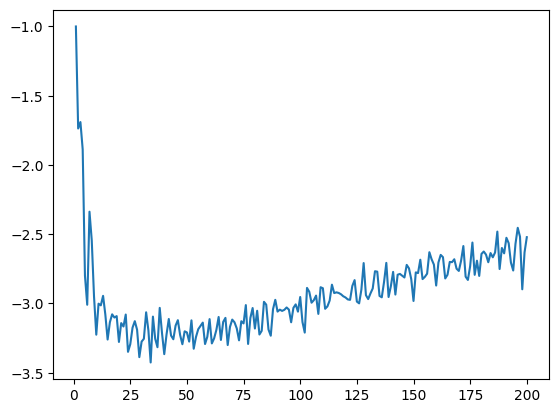

In [3]:
from matplotlib import pyplot as plt

num_bins = 201

risks = [j_hat_hist(X1, m)[0] for m in range(1, num_bins)]
n_bins = risks.index(min(risks))

plt.plot(range(1, num_bins), risks)

plt.show()

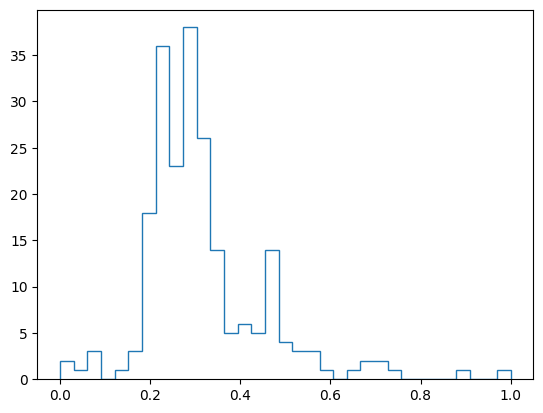

In [4]:
counts, bins, _ = plt.hist(X1, n_bins, histtype='step')
plt.show()

0.6227606987852935


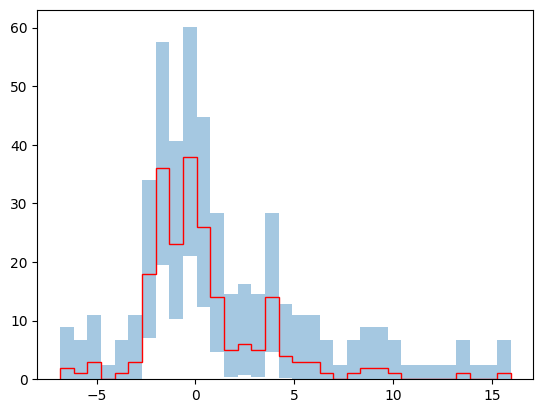

In [5]:
l_x, u_x = hist_band(counts/len(X), n_bins, len(X))

u_x_new = [0.]
u_x_new.extend(u_x)

l_x_new = [0.]
l_x_new.extend(l_x)

plt.fill_between(bins*(X.max() - X.min())+X.min(), l_x_new, u_x_new, step='pre', alpha=0.4)
plt.hist(X, n_bins, histtype='step', color='r')

plt.show()

In [6]:
def k_star(x: np.ndarray):
    return st.norm.pdf(x, loc=0, scale=np.sqrt(2)) - 2*st.norm.pdf(x)

def j_hat_kde(x: np.ndarray, h: float):
    n = len(x)
    k_star_ij = k_star(np.subtract.outer(x, x)/h).sum()

    return 1/(h*n**2) * k_star_ij + 2/(h*n) * st.norm.pdf(0)

0.25


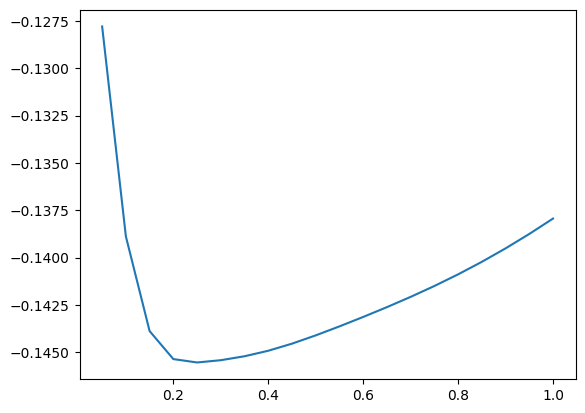

In [7]:
m = 20

risks_kde = [j_hat_kde(X, i/m) for i in range(1, m+1)]
kde_idx = risks_kde.index(min(risks_kde)) + 1
h = kde_idx/m
print(h)

plt.plot(np.array(range(1, m+1))/m, risks_kde)

plt.show()

In [8]:
n = len(X)
X_min, X_max = X.min(), X.max()
x_vals = np.arange(X_min - 0.05 * (X_max-X_min), X_max + 0.05 * (X_max-X_min), step=(X_max-X_min)/1000)

t = np.repeat(x_vals.reshape(-1, 1), len(X), axis=1)

In [9]:
def kde_hat(x: np.ndarray, h: float, alpha: float=0.05):
    n = len(x)
    X_min, X_max = x.min(), x.max()
    x_vals = np.arange(X_min - 0.05 * (X_max-X_min), X_max + 0.05 * (X_max-X_min), step=(X_max-X_min)/1000)

    t = np.repeat(x_vals.reshape(-1, 1), n, axis=1)

    m = (X_max - X_min)/(3*h)
    q = st.norm.ppf( (1 + (1-alpha)**(1/m)) / 2 )

    Y = 1/h * st.norm.pdf( (t-x)/h )
    f_hat = Y.mean(axis=1)

    s2 = 1/(n-1) * np.sum(( Y - f_hat.reshape(-1,1) )**2, axis=1)
    se = np.sqrt(s2/n)

    return f_hat, np.maximum(f_hat - q*se, 0), f_hat + q*se

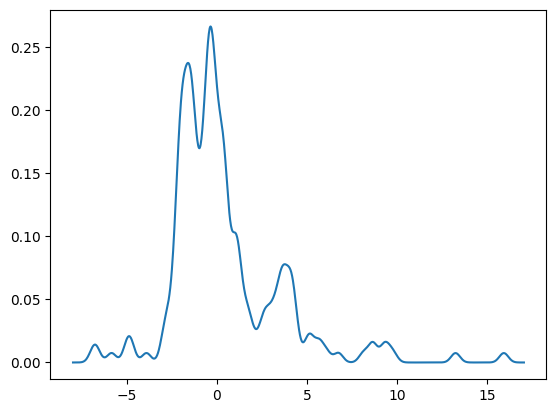

In [10]:
temp = st.norm.pdf((t - X)/h)
temp2 = temp.sum(axis=1)/(n*h)

plt.plot(x_vals, temp2)
plt.show()

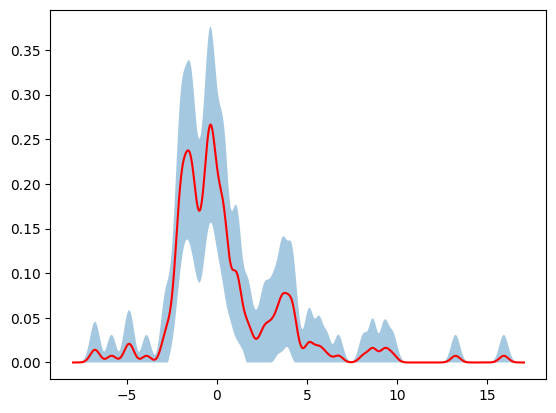

In [11]:
f_kde, l_kde, u_kde = kde_hat(X, h)

plt.plot(x_vals, f_kde, color='r')
# plt.plot(x_vals, l_kde)
# plt.plot(x_vals, u_kde)
plt.fill_between(x_vals, l_kde, u_kde, alpha=0.4)
plt.show()